# Deform a hemisphere into a cow's head

---


This notebook attempts to solve the problem of deforming a hemisphere into a cow's head.


Import the required modules.


In [8]:
import numpy as np
import pyvista as pv
import pycpd as cpd
import torch
import numerical_geometry as ng

---

## 1 - Create source and target meshes


Create a mesh of a hemisphere and compute normals using the `pv.Sphere()` amd `compute_normals()`functions.


In [9]:
hemisphere_mesh = pv.Sphere(
    radius=0.75, theta_resolution=100, phi_resolution=100, end_phi=90
).compute_normals()
hemisphere_mesh.plot(show_edges=True)

Widget(value='<iframe src="http://localhost:61175/index.html?ui=P_0x324e6f110_3&reconnect=auto" class="pyvista…

Import a mesh of a cow's head from PyVista. A cow's head is a complicated geometry which is topologically equivalent to the hemisphere mesh. It should be a good mesh to benchmark different deformation algorithms. We will compute the vertex normals using the `compute_normals()` function. We will rotate, translate and scale the cow's head mesh so that it lines up nicely with the hemisphere mesh.


In [10]:
cow_head_filename = pv.examples.download_cow_head(load=False)
cow_head_mesh = pv.get_reader(cow_head_filename).read().compute_normals()
cow_head_mesh.plot(show_edges=True)

cow_head_mesh = cow_head_mesh.rotate_x(angle=90)
cow_head_mesh = cow_head_mesh.rotate_y(angle=-62)
cow_head_mesh = cow_head_mesh.translate((-0.8, 0, -3.7))
cow_head_mesh.points = cow_head_mesh.points / np.mean(
    np.linalg.norm(cow_head_mesh.points, axis=1)
)

Widget(value='<iframe src="http://localhost:61175/index.html?ui=P_0x3064e7750_4&reconnect=auto" class="pyvista…

Plot the source and target mesh.


In [11]:
plotter = pv.Plotter()
plotter.add_mesh(hemisphere_mesh, color="lightblue", opacity=0.5)
plotter.add_mesh(cow_head_mesh, color="brown", opacity=0.5, show_edges=True)
plotter.show()

Widget(value='<iframe src="http://localhost:61175/index.html?ui=P_0x324b3b390_5&reconnect=auto" class="pyvista…

---

## 2 - Use `pycpd` to deform the hemisphere to the cow's head


First, we will try using the `pypcd` [1] package to deform the hemisphere mesh to the cow's head mesh. `pypcd` is a NumPy implementation of the Coherent Point Drift (CPD) algorithm by Myronenko and Song [2].

After running 5 iterations, the general shape of the cow's head is captured fairly well. However, the ears and horns of the cow are not distinct, and the hole for the neck is in completely the wrong place!


In [ ]:
NUM_ITERATIONS = 5

hemisphere_mesh_deformed = hemisphere_mesh.copy()

for i in range(NUM_ITERATIONS):
    # Create a deformable registration object.
    deformable_registration = cpd.DeformableRegistration(
        alpha=0.05,
        X=np.array(cow_head_mesh.points),
        Y=np.array(hemisphere_mesh_deformed.points),
    )

    # Run the deformable registration, and update the hemisphere mesh.
    transformed_hemisphere_points, _ = deformable_registration.register()
    hemisphere_mesh_deformed.points = transformed_hemisphere_points

# Plot the meshes in separate subplots.
pl = pv.Plotter(shape=(1, 2))

pl.subplot(0, 0)
pl.add_mesh(hemisphere_mesh_deformed, color="lightblue")
pl.add_text("Deformed hemisphere", font_size=10)

pl.subplot(0, 1)
pl.add_mesh(cow_head_mesh, color="orange")
pl.add_text("Cow's head", font_size=10)

pl.show()

In [ ]:
pl = pv.Plotter()
pl.add_mesh(hemisphere_mesh_deformed, color="lightblue")
pl.show()

---

## 3 - Use a neural network to learn the deformation


We will now try to solve the problem using a neural network. We will aim to learn a function $f: \mathbb{R}^3 \rightarrow \mathbb{R}^3$ that maps the points of the source mesh to the deformation field. One benefit of this approach is that we can learn the function on a low dimensional representation (i.e. sparse source and target meshes), and then apply the function to a dense source mesh.


Set the device to MPS if available (you will need to modify this block of code if you aren't using an Apple silicon device).


In [12]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using {device} device.")

Using mps device.


### 3.1 - Loss function


In order to optimize the parameters, we need a loss function. Our loss function will include 3 terms: a Chamfer distance term, a deformation magnitude regularization term, and a Laplacian regularization term.


In [13]:
lambda_deformation = 1e-3
lambda_laplacian = 1e-3


def loss_function(source, target, deformation):
    """
    Loss function
    =============

    Computes the loss.
    """
    chamfer_distance = ng.chamfer_distance(source + deformation, target)
    deformation_loss = ng.deformation_loss(deformation)
    laplacian_loss = ng.laplacian_loss(source, deformation)

    loss = (
        chamfer_distance
        + (lambda_deformation * deformation_loss)
        + (lambda_laplacian * laplacian_loss)
    )
    return loss

### 3.2 - Create and train the model


We can initialize a multilayer perceptron (MLP) using `ng.NeuralNetwork()`. We can train the model using the `train_model()` function.


[10/200]: loss = 0.047939
[20/200]: loss = 0.038250
[30/200]: loss = 0.030354
[40/200]: loss = 0.023968
[50/200]: loss = 0.019499
[60/200]: loss = 0.016058
[70/200]: loss = 0.014984
[80/200]: loss = 0.012408
[90/200]: loss = 0.011913
[100/200]: loss = 0.011884
[110/200]: loss = 0.011760
[120/200]: loss = 0.010702
[130/200]: loss = 0.010328
[140/200]: loss = 0.010120
[150/200]: loss = 0.010112
[160/200]: loss = 0.009607
[170/200]: loss = 0.009267
[180/200]: loss = 0.009236
[190/200]: loss = 0.009744
[200/200]: loss = 0.009155


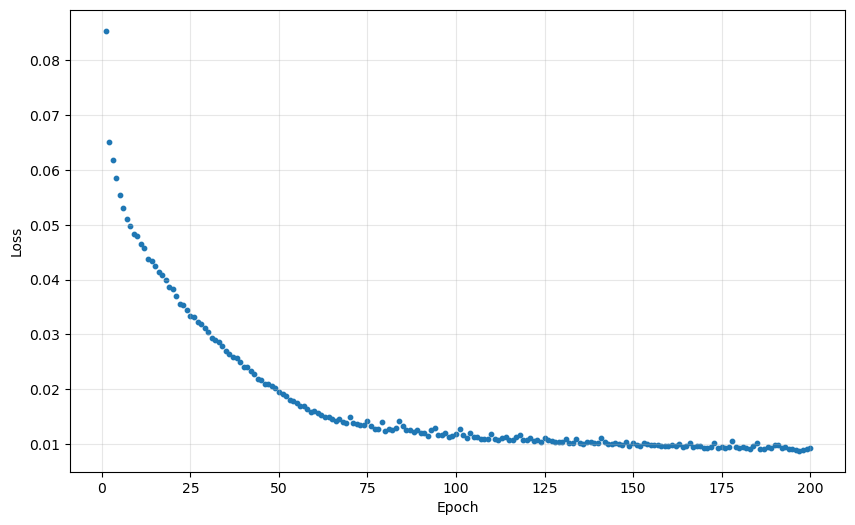

In [14]:
model = ng.NeuralNetwork(parameters=128, layers=4).to(device)

model.train_model(
    source_mesh=hemisphere_mesh,
    target_mesh=cow_head_mesh,
    device=device,
    loss_function=loss_function,
    optimizer_type="SGD",
    epochs=200,
    batch_size=512,
    target_batch_size=1000,
    learning_rate=1e-1,
    print_every=10,
)

### 3.3 - Testing


Now that we have trained the model, we can use it to calculate a deformation field, and then apply the deformation field to the source.


In [ ]:
hemisphere_mesh = pv.Sphere(
    radius=0.75, theta_resolution=200, phi_resolution=200, end_phi=90
)
deformation = model.get_deformation_field(hemisphere_mesh, device)

ng.plot_deformation(
    source_mesh=hemisphere_mesh, deformation=deformation, show_edges=False
)

Widget(value='<iframe src="http://localhost:61175/index.html?ui=P_0x34c2474d0_6&reconnect=auto" class="pyvista…

---

## 4 - Use a neural network with multiple stages


The approach from the previous section didn't work very well, so we will try training over multiple stages, and see if that improves the performance at all.


Set the device to MPS if available (you will need to modify this block of code if you aren't using an Apple silicon device).


In [16]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using {device} device.")

Using mps device.


### 4.1 - Loss function


In order to optimize the parameters, we need a loss function. To start with, the loss function will have two terms: a Chamfer distance term, and a term which penalizes large deformations. The Chamfer distance provides a measure of how close two point clouds are.


In [17]:
lambda_deformation = 1e-3
lambda_laplacian = 1e-3


def loss_function(source, target, deformation):
    """
    Loss function
    =============

    Computes the loss.
    """
    chamfer_distance = ng.chamfer_distance(source + deformation, target)
    deformation_loss = ng.deformation_loss(deformation)
    laplacian_loss = ng.laplacian_loss(source, deformation)

    loss = (
        chamfer_distance
        + (lambda_deformation * deformation_loss)
        + (lambda_laplacian * laplacian_loss)
    )
    return loss

### 4.2 - Create and train the model over multiple stages


We now have everything we need to train the model. The training is handled by the `train_model()` function. We will train the model over 5 stages. You may want to try modifying this code to vary the hyperparameters/loss function at each training stage.



Stage 1:
--------
[10/40]: loss = 0.025272
[20/40]: loss = 0.013964
[30/40]: loss = 0.012089
[40/40]: loss = 0.010581


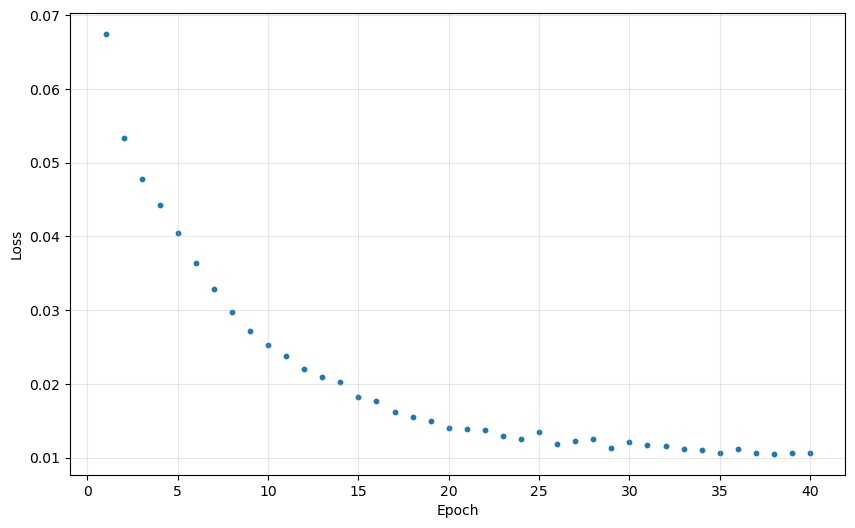


Stage 2:
--------
[10/40]: loss = 0.009687
[20/40]: loss = 0.009668
[30/40]: loss = 0.009651
[40/40]: loss = 0.009597


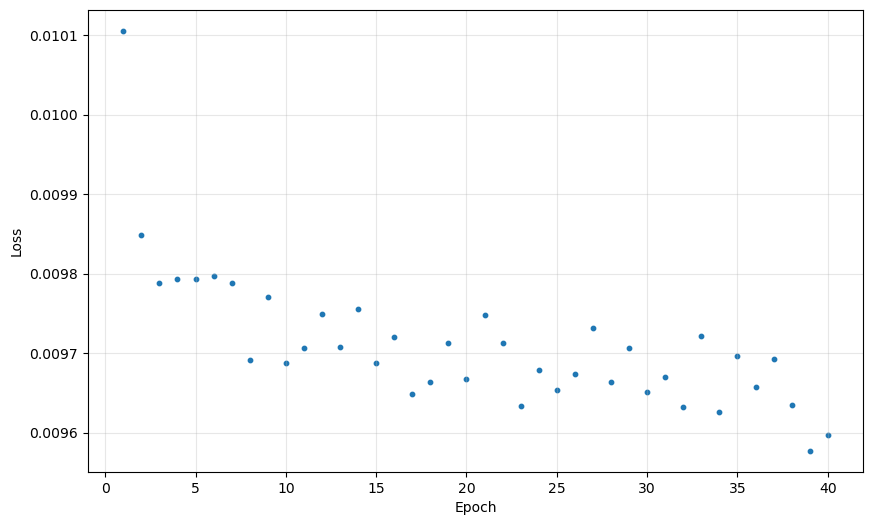


Stage 3:
--------
[10/40]: loss = 0.009485
[20/40]: loss = 0.009408
[30/40]: loss = 0.009422
[40/40]: loss = 0.009354


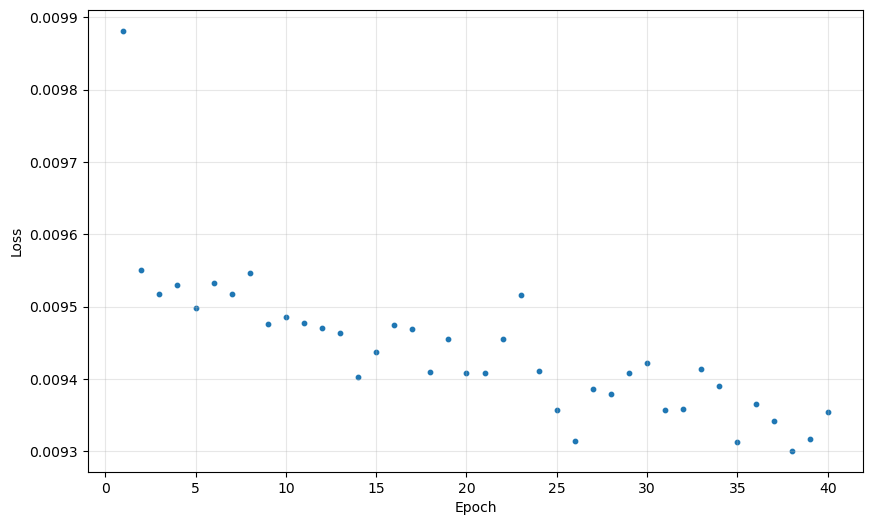


Stage 4:
--------
[10/40]: loss = 0.009230
[20/40]: loss = 0.009240
[30/40]: loss = 0.009172
[40/40]: loss = 0.009099


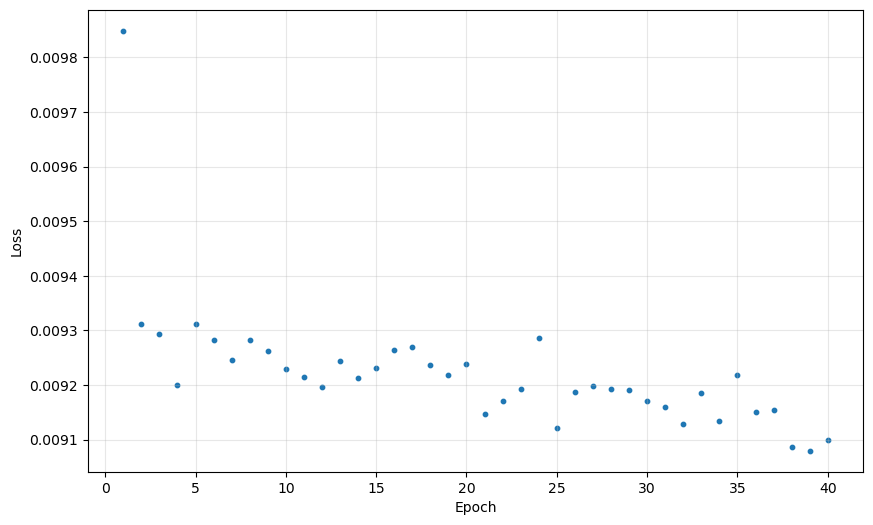


Stage 5:
--------
[10/40]: loss = 0.009043
[20/40]: loss = 0.009018
[30/40]: loss = 0.009003
[40/40]: loss = 0.008920


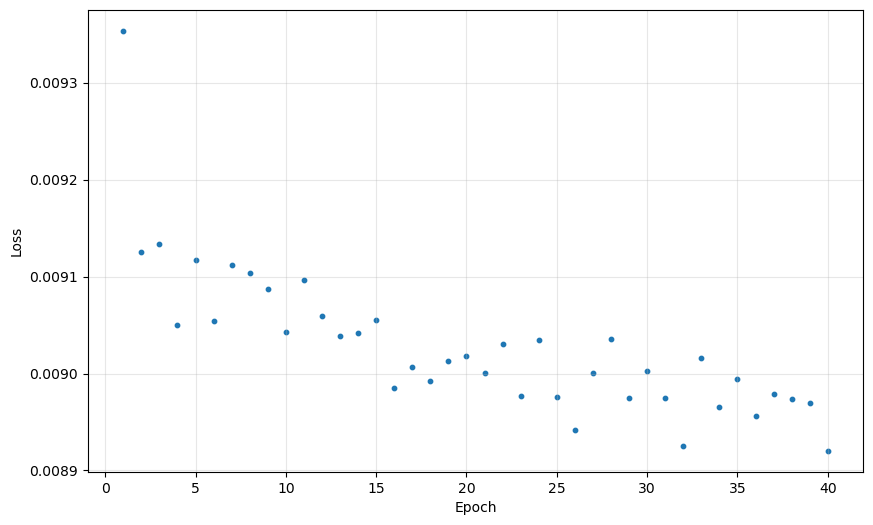

In [19]:
source = torch.from_numpy(hemisphere_mesh.points).float().to(device)

stages = 5
deformation_history = []

for stage in range(stages):
    print(f"\nStage {stage+1}:\n--------")

    # Find the current source.
    if stage > 0:
        current_source = current_source + current_deformation
    else:
        current_source = source

    model = ng.NeuralNetwork(parameters=128, layers=4).to(device)

    model.train_model(
        source_mesh=current_source,
        target_mesh=cow_head_mesh,
        device=device,
        loss_function=loss_function,
        optimizer_type="SGD",
        epochs=40,
        batch_size=512,
        target_batch_size=1000,
        learning_rate=1e-1,
    )

    current_deformation = model(current_source).detach()
    deformation_history.append(current_deformation)

### 4.3 - Testing


We can calculate the full deformation field using `deformation_history`.


In [24]:
total_deformation = torch.zeros_like(deformation_history[0])

for deformation in deformation_history:
    total_deformation += deformation

total_deformation = total_deformation.to("cpu").detach().numpy()

We can now apply the deformation field to the source.


In [25]:
ng.plot_deformation(
    source_mesh=hemisphere_mesh,
    deformation=total_deformation,
    show_edges=False,
)

Widget(value='<iframe src="http://localhost:61175/index.html?ui=P_0x3985e0050_7&reconnect=auto" class="pyvista…

---

## References


[1] - Khallaghi, S. siavashk/pycpd. (2025) (https://github.com/siavashk/pycpd).

[2] - Myronenko, A. & Song, X. Point-Set Registration: Coherent Point Drift. IEEE Trans. Pattern Anal. Mach. Intell. 32, 2262–2275 (2010) (https://doi.org/10.1109/TPAMI.2010.46).
